# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Map-of-sales" data-toc-modified-id="Map-of-sales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Map of sales</a></div><div class="lev1 toc-item"><a href="#Heat-maps" data-toc-modified-id="Heat-maps-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Heat maps</a></div><div class="lev1 toc-item"><a href="#Heat-map-of-residuals" data-toc-modified-id="Heat-map-of-residuals-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Heat map of residuals</a></div>

In [1]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
import PDMats: AbstractPDMat, PDMat
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end
sum(believable)

22203

In [3]:
Tucson_sales[:logSalePrice] = log(Tucson_sales[:SalePrice]);
nobsv_ = sum(believable)
for_mm = copy(Tucson_sales[believable,:])
for_mm[:SQFT] =  for_mm[:SQFT] .- mean(for_mm[:SQFT])
for_mm[:SQFT] = for_mm[:SQFT] ./ std(for_mm[:SQFT])
for_mm[:ROOMS] = for_mm[:ROOMS] .- mean(for_mm[:ROOMS])
for_mm[:ROOMS] = for_mm[:ROOMS] ./ std(for_mm[:ROOMS])
for_mm[:STORIES] = for_mm[:STORIES] .- mean(for_mm[:STORIES])
for_mm[:STORIES] = for_mm[:STORIES] ./ std(for_mm[:STORIES])
reordering = collect(1:nobsv_)
schdistrs = unique(for_mm[:,:SchDistr])
istart = 1
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
schdistr_indices = Dict{String,Vector{Int}}()
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    schdistr_indices[name] = indices
end
;

In [4]:
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
for name in schdistrs
    Y_dict[name] = for_mm[schdistr_indices[name], :logSalePrice]
    X_dict[name] = for_mm[schdistr_indices[name],[:X_PRJ, :Y_PRJ]]
end
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

# Map of sales

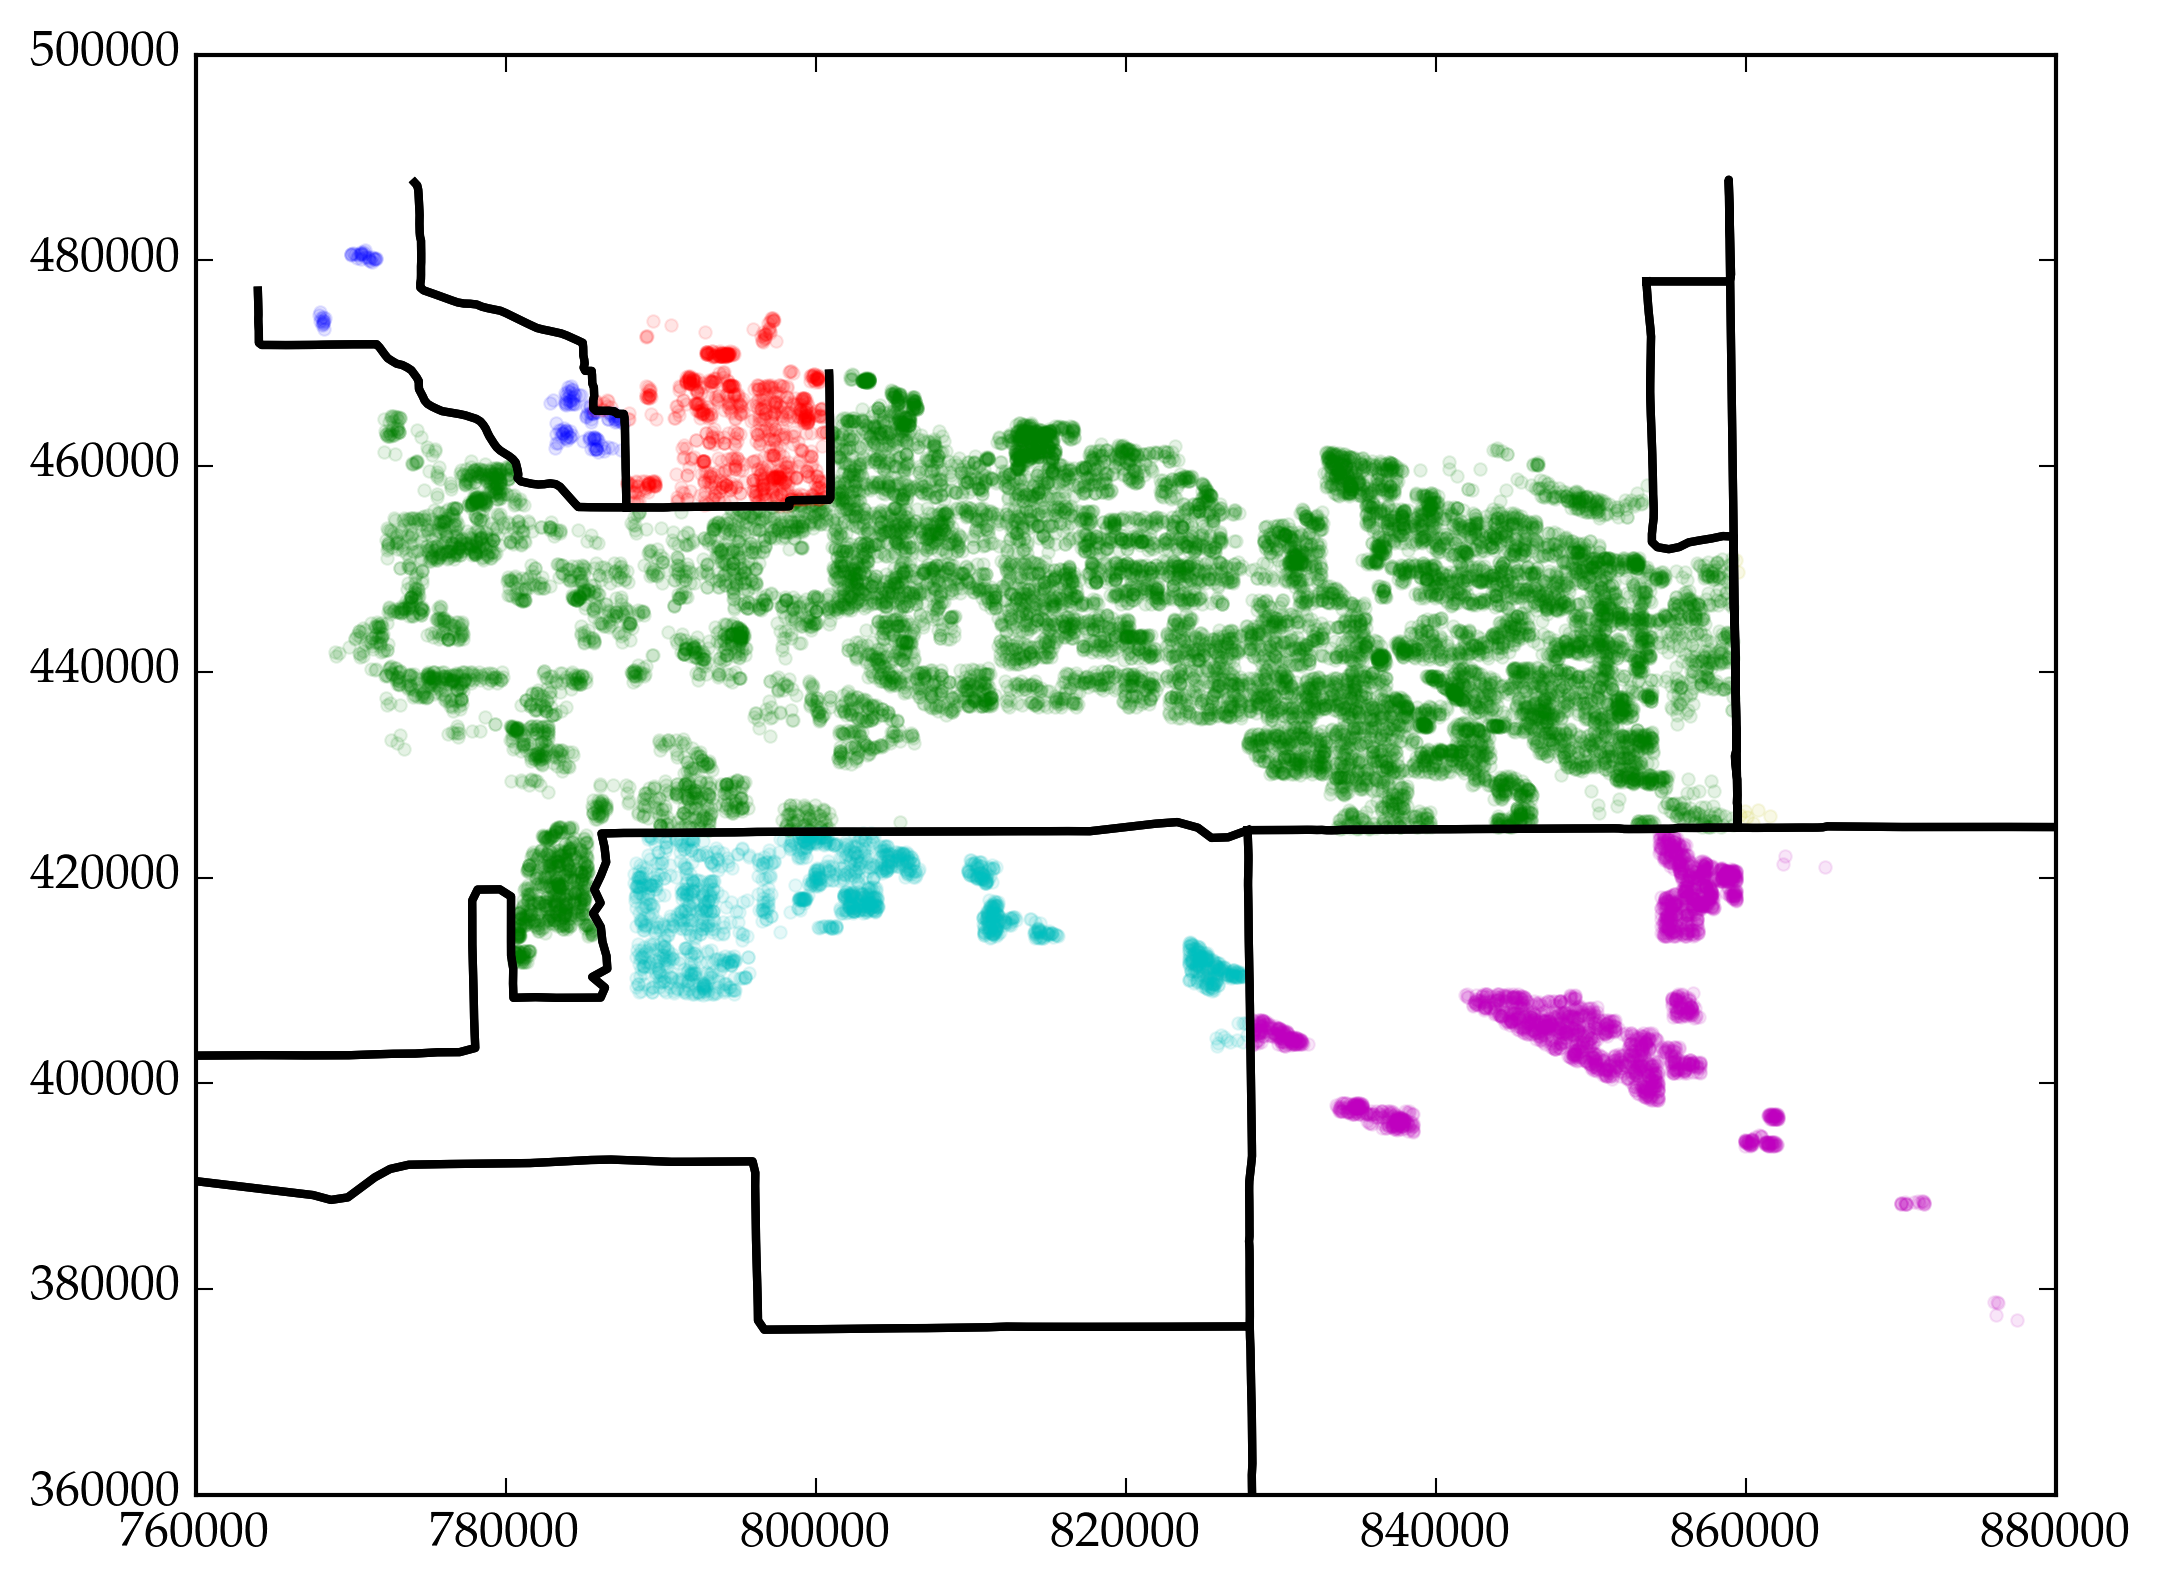

In [6]:
for name in schdistrs
    plt.plot(X_dict[name]'[1,:], X_dict[name]'[2,:], ".", alpha=0.1)
end
_xlim = plt.xlim()
_ylim = plt.ylim()
for (key,val) in sentinels
    X◫ = hcat(val.coordinates...)
    plt.plot(X◫[1,:], X◫[2,:], color="black", linewidth=2)
end
plt.xlim(_xlim)
plt.ylim(_ylim)
;

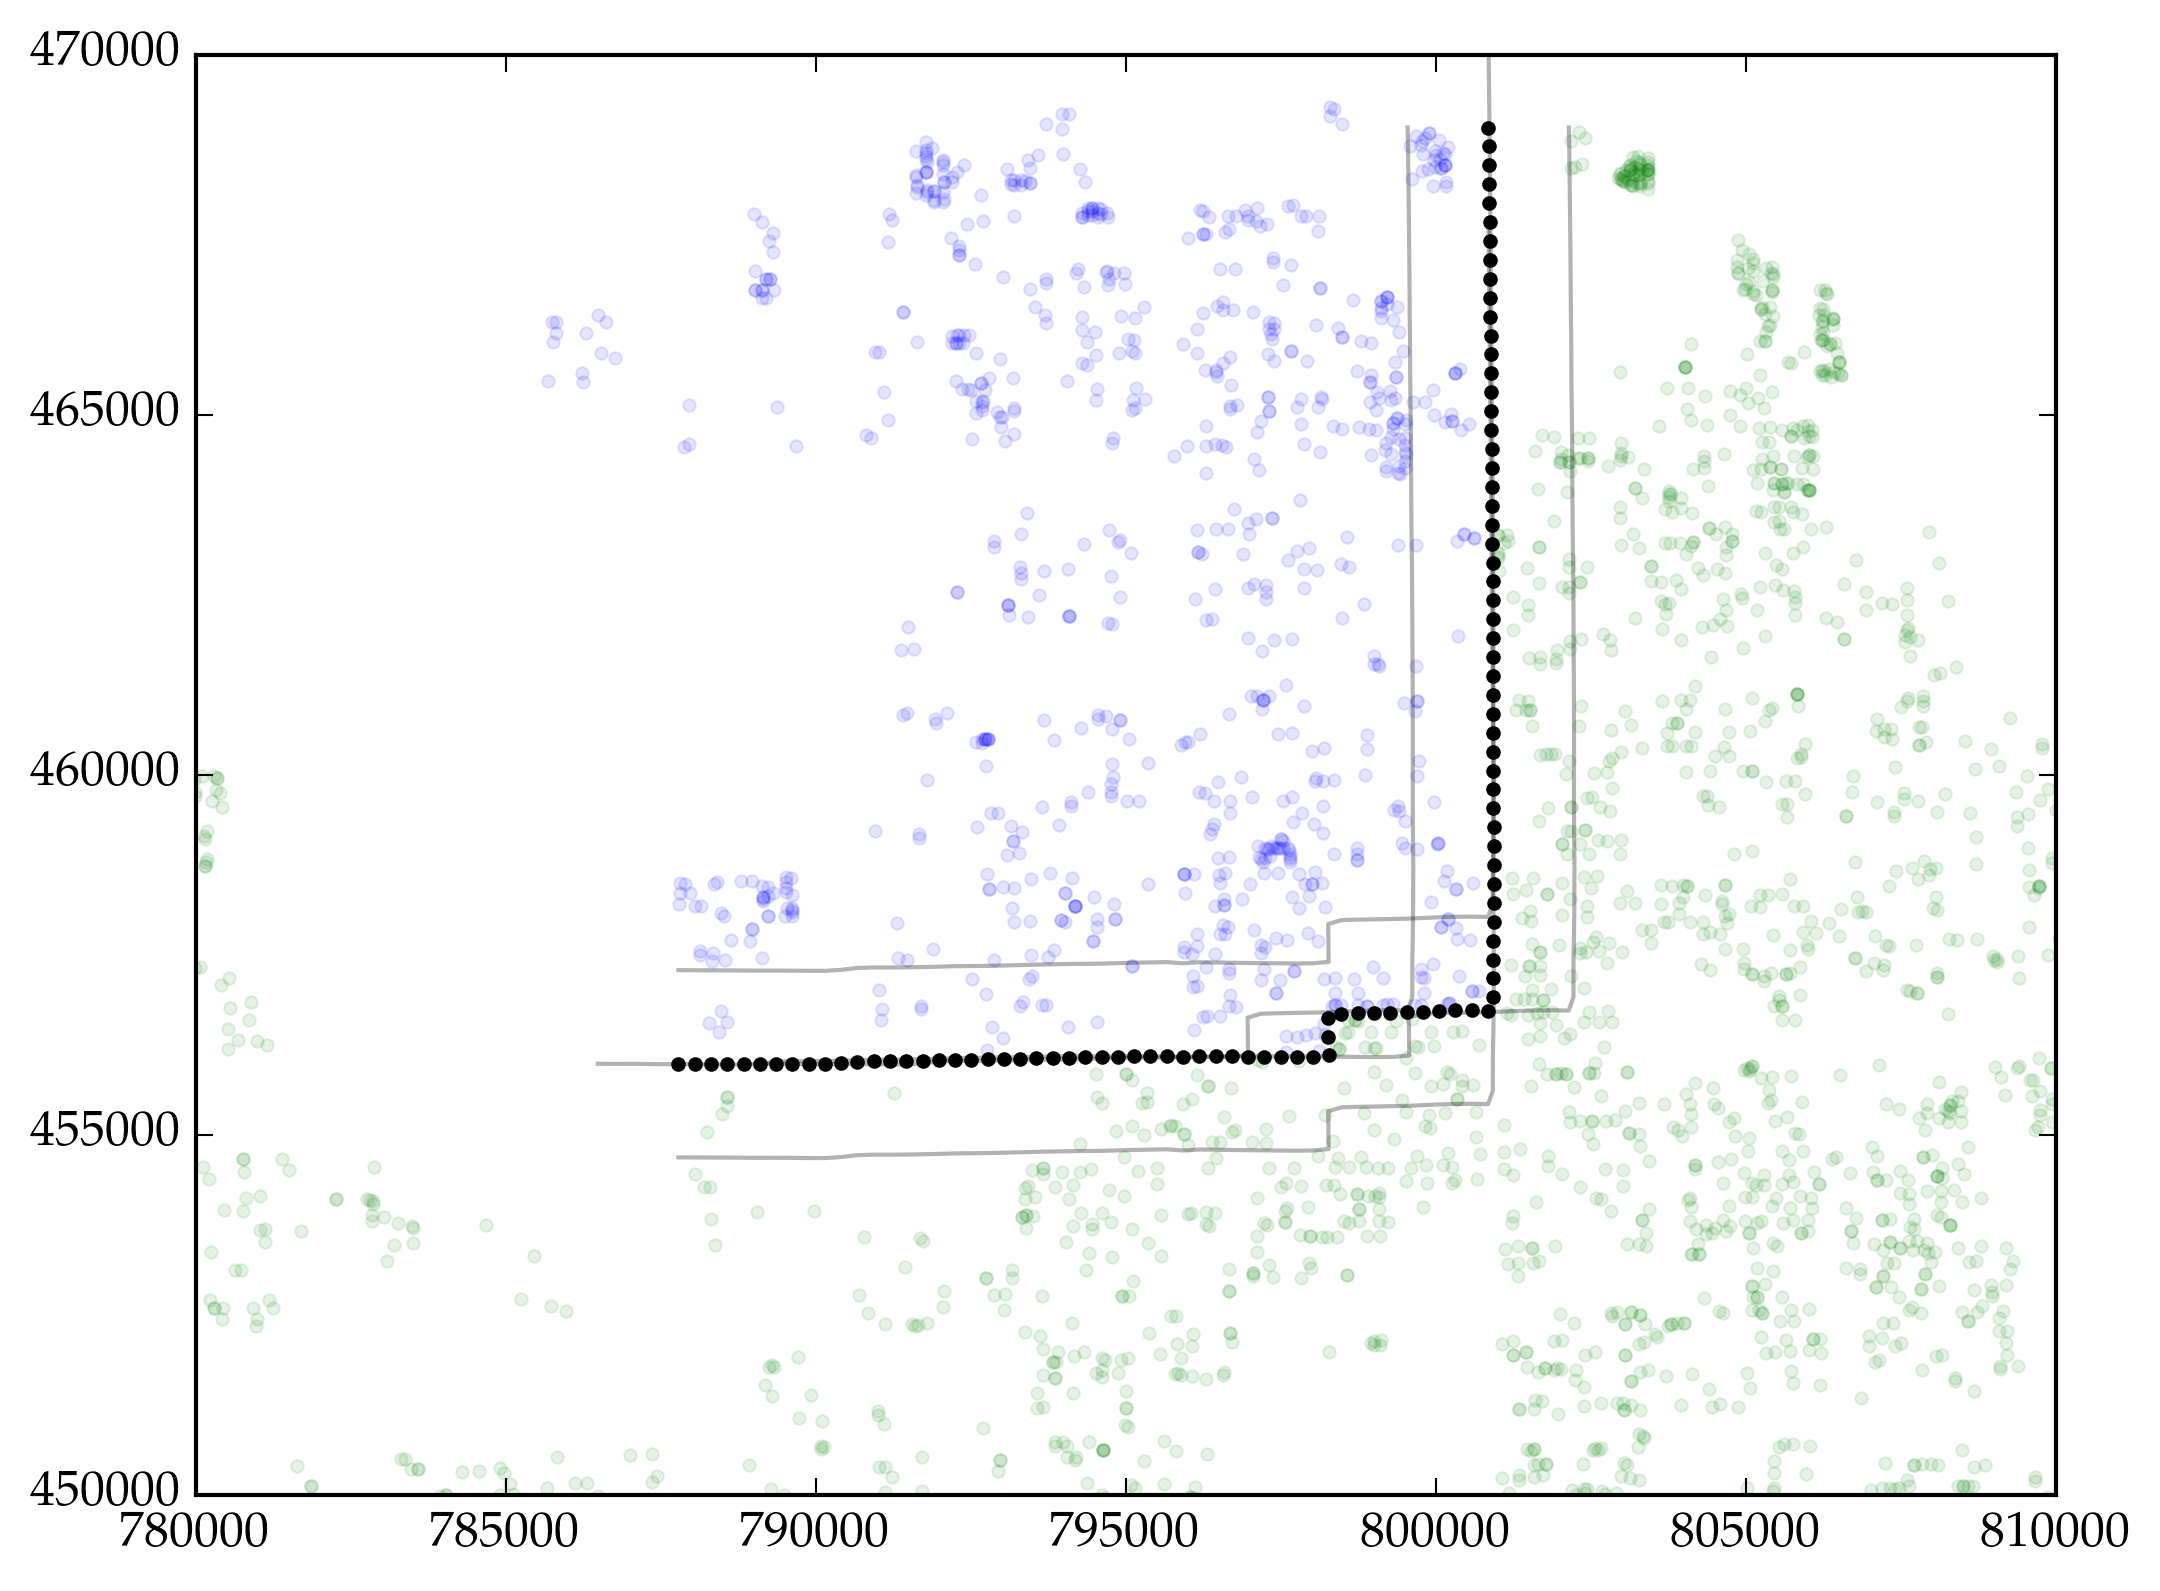

In [8]:
distrA = "Amphitheater Unified District"
distrB = "Tucson Unified District"
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
n◫ = size(X◫, 2)
for name in (distrA, distrB)
    plt.plot(X_dict[name]'[1,:], X_dict[name]'[2,:], ".", alpha=0.1)
end
_xlim = plt.xlim()
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
plt.plot(X◫[1,:], X◫[2,:], color="black", ".")
_L=1300
plt.plot(X◫[1,:].-_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:].+_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].-_L, color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].+_L, color="black", alpha=0.3)
plt.xlim(780000, 810000)
plt.ylim(450000,470000)
;

# Heat maps

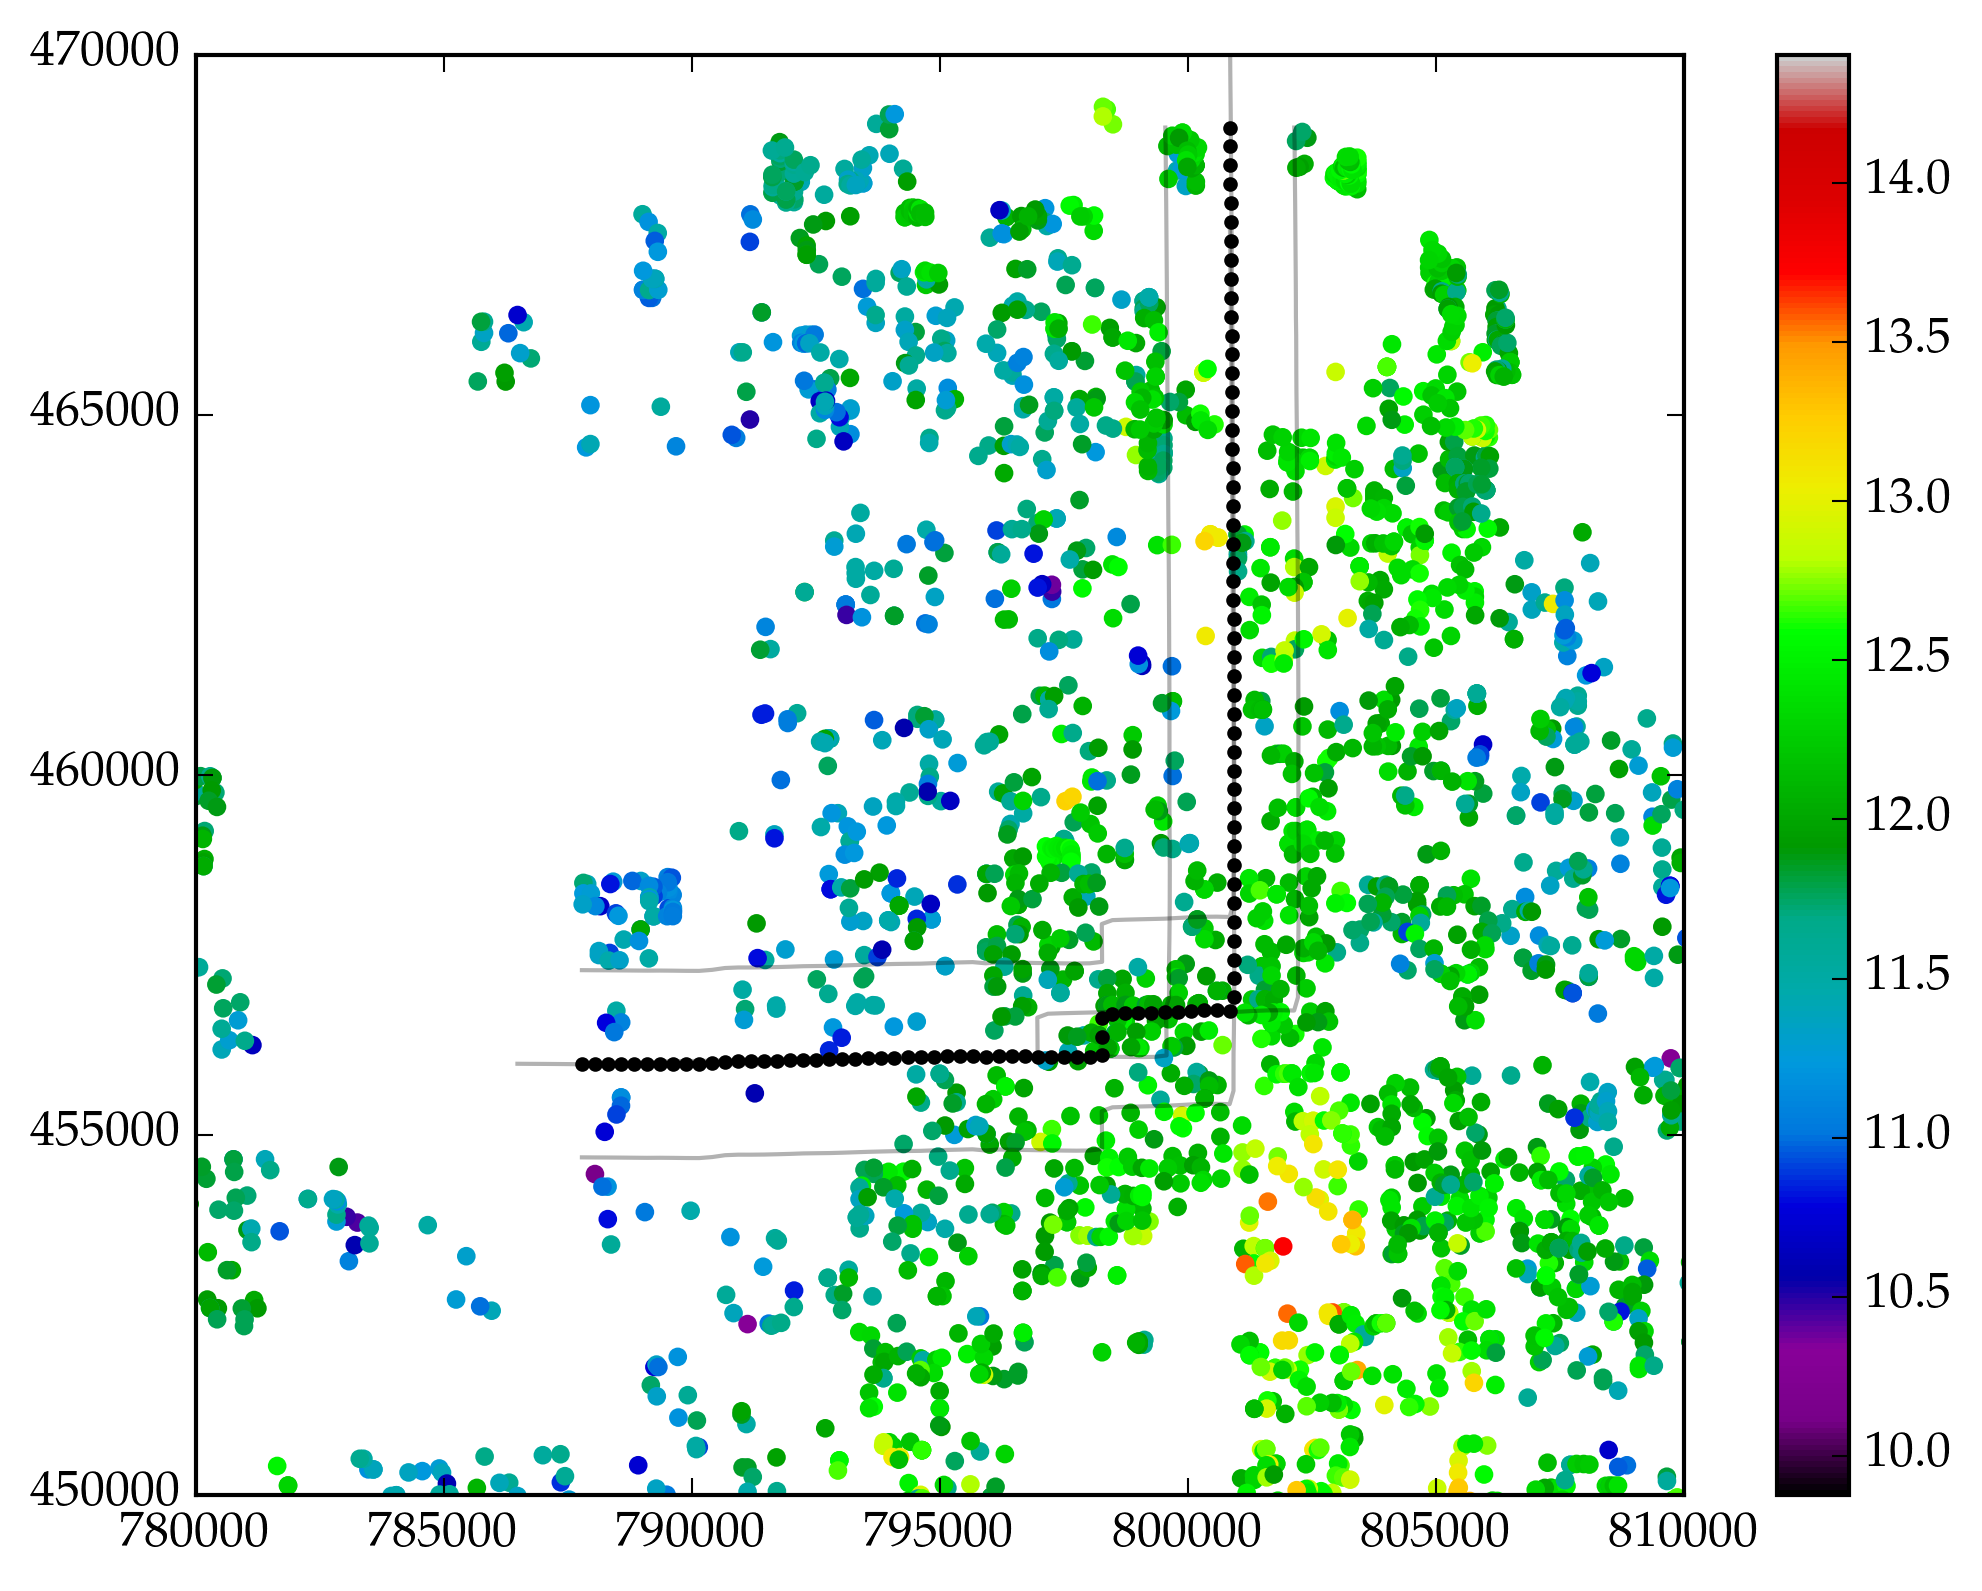

In [41]:
distrA = "Amphitheater Unified District"
distrB = "Tucson Unified District"
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
n◫ = size(X◫, 2)
minY,maxY = extrema(for_mm[:logSalePrice])
for name in (distrA, distrB)
    plt.scatter(X_dict[name]'[1,:], X_dict[name]'[2,:],c=Y_dict[name], cmap="spectral", edgecolor="None", vmin=minY, vmax=maxY)
end
_xlim = plt.xlim()
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
plt.plot(X◫[1,:], X◫[2,:], color="black", ".")
_L=1300
plt.plot(X◫[1,:].-_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:].+_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].-_L, color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].+_L, color="black", alpha=0.3)
plt.xlim(780000, 810000)
plt.ylim(450000,470000)
plt.colorbar()
;

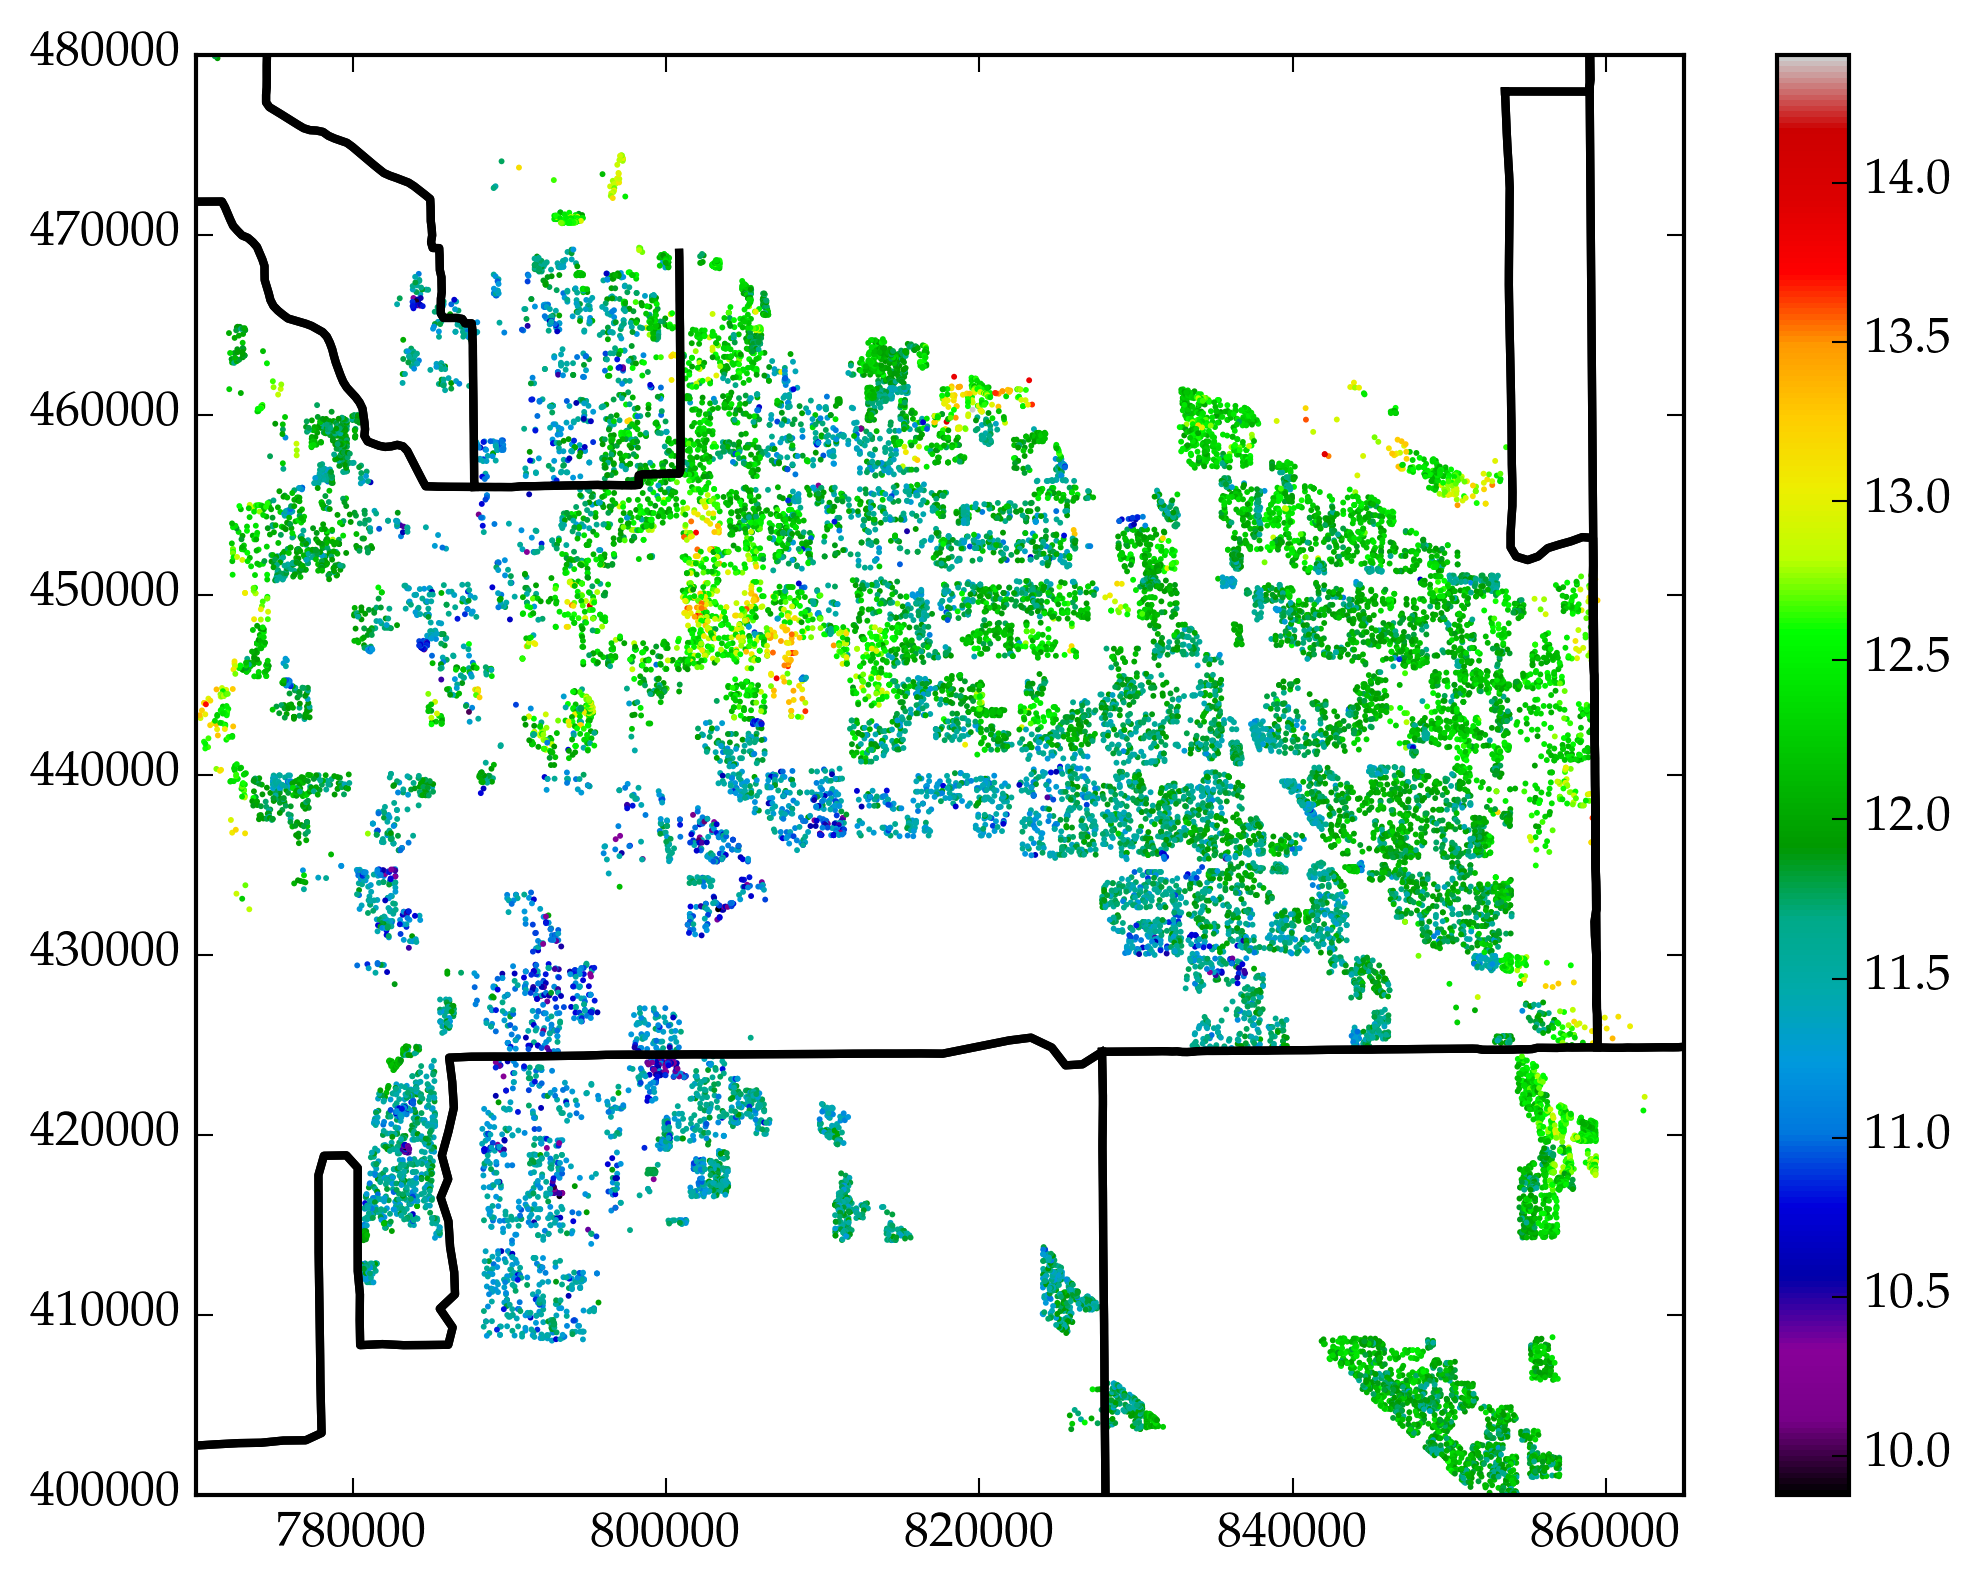

In [55]:
for name in schdistrs
    plt.scatter(X_dict[name]'[1,:], X_dict[name]'[2,:],c=Y_dict[name], s=2, 
        cmap="spectral", edgecolor="None", vmin=minY, vmax=maxY)
end
for (key,val) in sentinels
    X◫ = hcat(val.coordinates...)
    plt.plot(X◫[1,:], X◫[2,:], color="black", linewidth=2)
end
plt.xlim(770000,865000)
plt.ylim(400000,480000)
plt.colorbar()
;

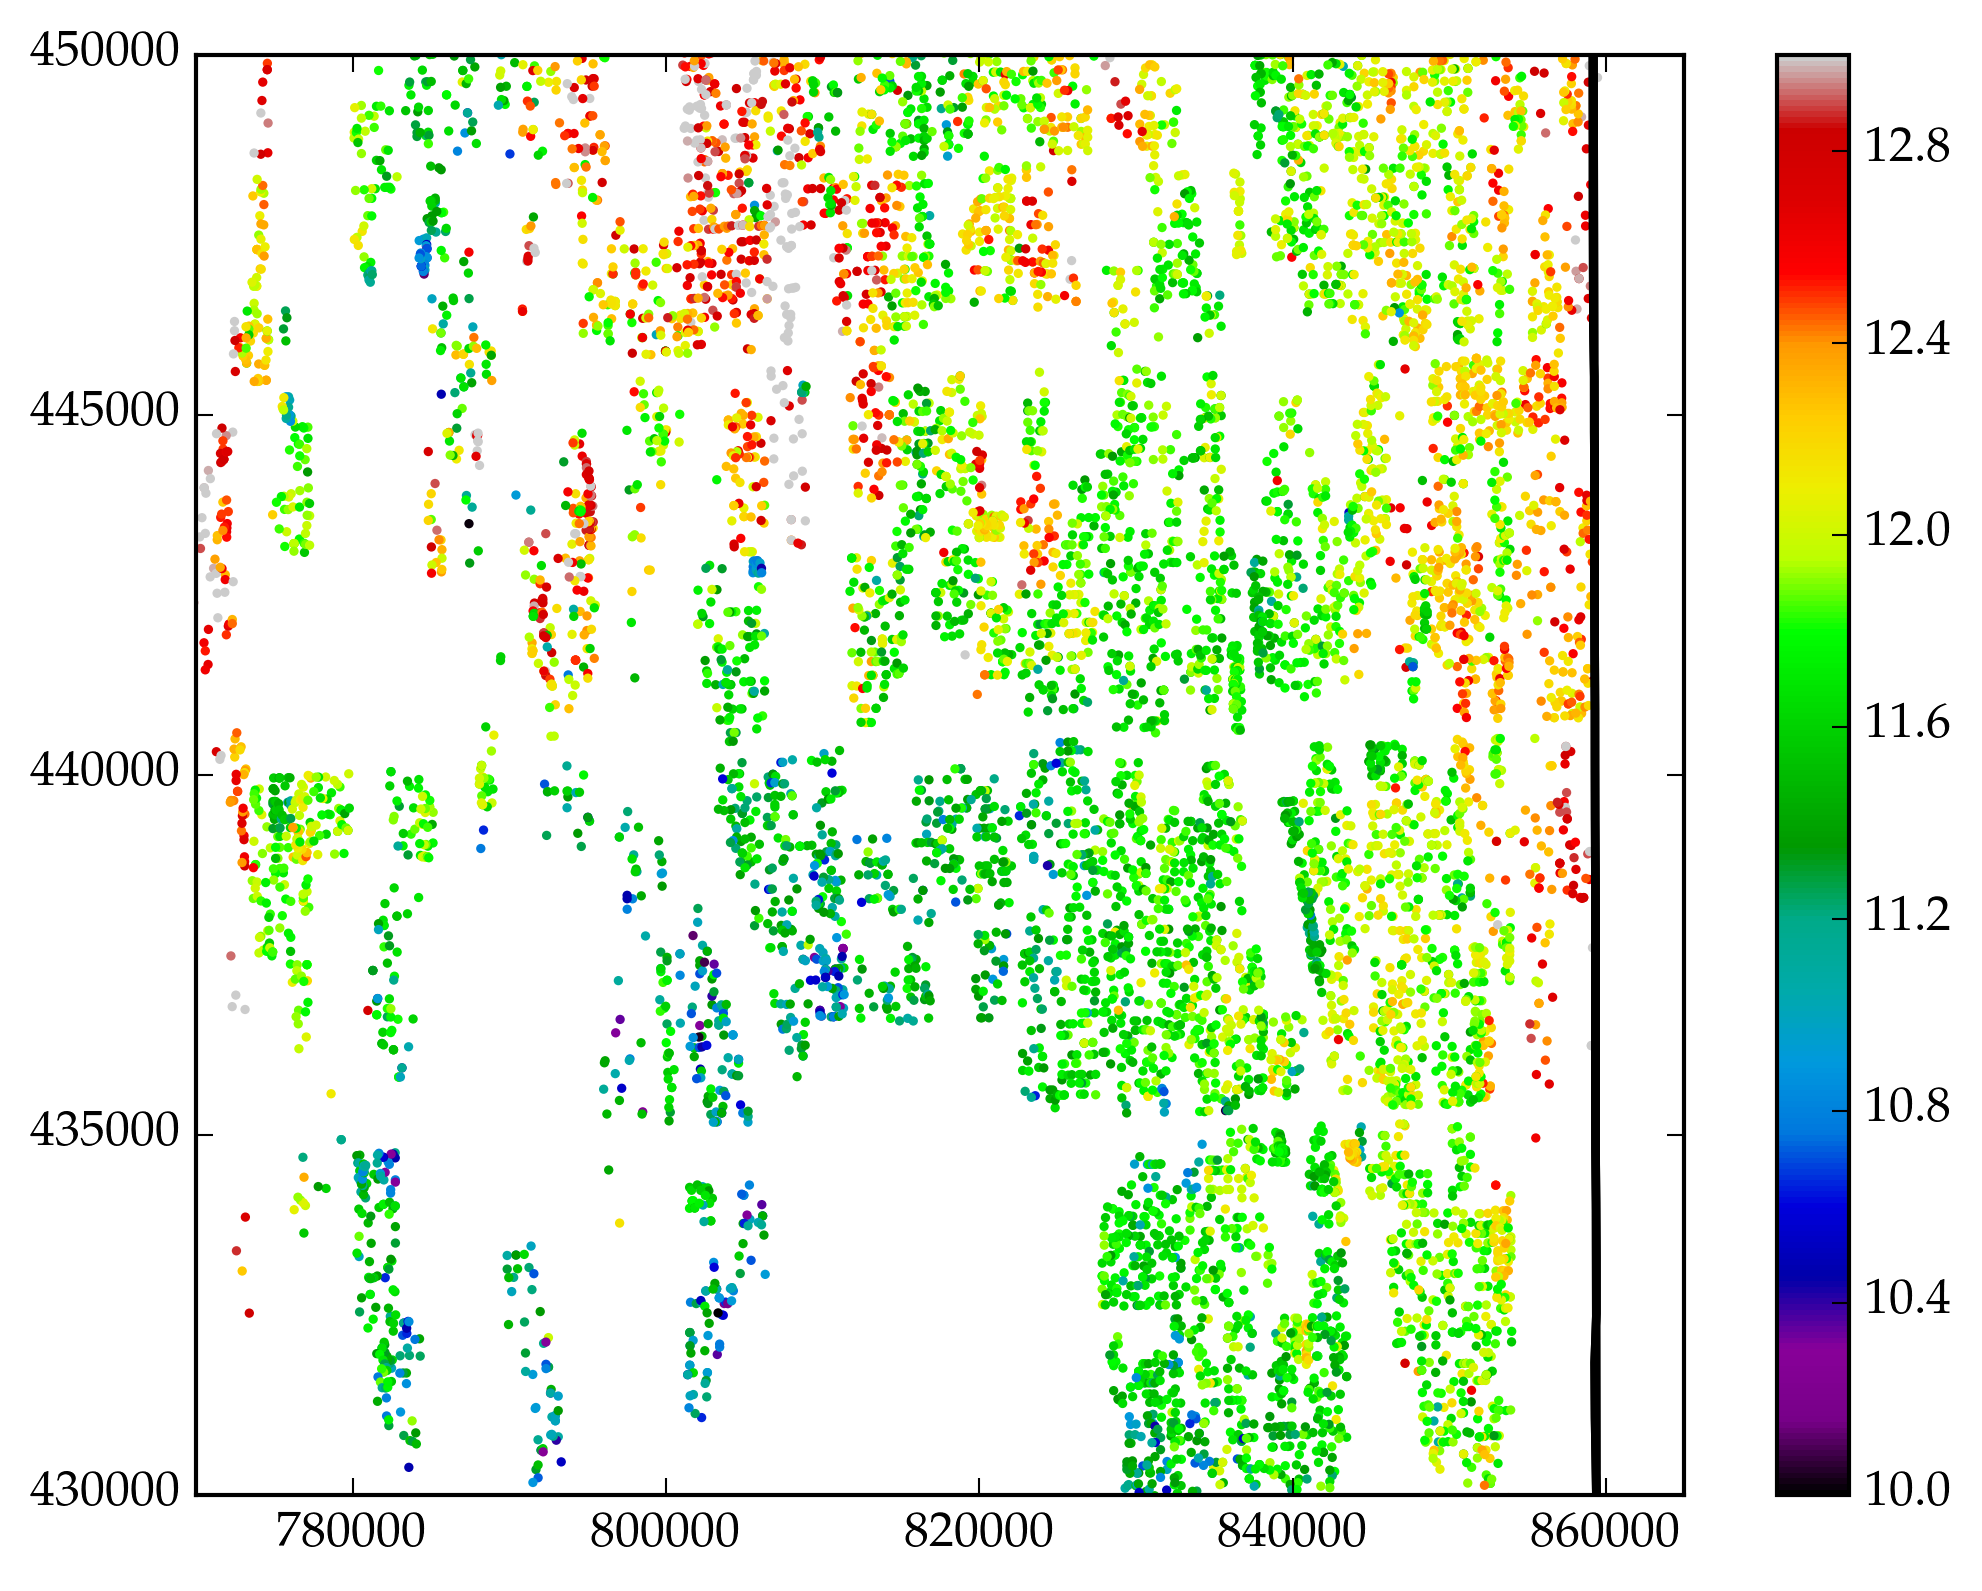

In [54]:
for name in schdistrs
    plt.scatter(X_dict[name]'[1,:], X_dict[name]'[2,:],c=Y_dict[name], s=5, 
        cmap="spectral", edgecolor="None", vmin=10.0, vmax=13.0)
end
for (key,val) in sentinels
    X◫ = hcat(val.coordinates...)
    plt.plot(X◫[1,:], X◫[2,:], color="black", linewidth=2)
end
plt.xlim(770000,865000)
plt.ylim(430000,450000)
plt.colorbar()
;

In [51]:
indmax(for_mm[for_mm[:Y_PRJ].<440000,:Y_PRJ])

2874

In [52]:
for_mm[2874,:]

1×110 DataFrames.DataFrame
│ Row │ x           │ ADDRESS            │ ADPARCEL_ │ ADPARCEL_I │ ADR_ID   │
├─────┼─────────────┼────────────────────┼───────────┼────────────┼──────────┤
│ 1   │ "116024850" │ "2833 W MEDLAR PL" │ 181807.0  │ 216763.0   │ 216212.0 │

│ Row │ AD_STREET │ AD_SUFFIX │ ANGLE │ AREA │ CITY_ID │ CODE │ DATE_ENTER   │
├─────┼───────────┼───────────┼───────┼──────┼─────────┼──────┼──────────────┤
│ 1   │ "MEDLAR"  │ "PL"      │ 0.0   │ 0.0  │ "TUC"   │ 0.0  │ "2000-02-19" │

│ Row │ LAT     │ LON      │ PERIMETER │ POLYGONID │ SCALE │ SOURCE       │
├─────┼─────────┼──────────┼───────────┼───────────┼───────┼──────────────┤
│ 1   │ 32.2363 │ -111.027 │ 0.0       │ 181807.0  │ 1.0   │ "PC DSD GIS" │

│ Row │ STATUS │ STREET        │ STREET_DIR │ STREET_IDX │ STREET_NAM  │
├─────┼────────┼───────────────┼────────────┼────────────┼─────────────┤
│ 1   │ "P"    │ "W MEDLAR PL" │ "W"        │ "MEDLA"    │ "MEDLAR PL" │

│ Row │ STREET_NO │ SUFFIX_DIR │ TILE_NAME │ X_HPGN   │ Y_HPGN   │ ZIPCITY  │
├─────┼───────────┼────────────┼───────────┼──────────┼──────────┼──────────┤
│ 1   │ 2833.0    │ NA         │ "E141304" │ 974957.0 │ 450842.0 │ "TUCSON" │

│ Row │ ZIPCODE │ geometry                                      │ SequenceNum │
├─────┼─────────┼───────────────────────────────────────────────┼─────────────┤
│ 1   │ 85745   │ "POINT (775163.6171414696 450800.2734154642)" │ 20122760492 │

│ Row │ SaleDate │ SalePrice │ PropertyType    │ IntendedUse  │
├─────┼──────────┼───────────┼─────────────────┼──────────────┤
│ 1   │ 201209   │ 109000    │ "Single Family" │ "PrimaryRes" │

│ Row │ Deed            │ Financing │ ValidationDescription │
├─────┼─────────────────┼───────────┼───────────────────────┤
│ 1   │ "Warranty Deed" │ "Cash"    │ "Good Sale"           │

│ Row │ BuyerSellerRelated │ Solar │ PersonalProperty │ PartialInterest │
├─────┼────────────────────┼───────┼──────────────────┼─────────────────┤
│ 1   │ "No"               │ "No"  │ "No"             │ "No"            │

│ Row │ RecordingDate │ TAXYEAR │ SFRCONDO │ COMPLEXID │ INSPECTION            │
├─────┼───────────────┼─────────┼──────────┼───────────┼───────────────────────┤
│ 1   │ "2012-10-02"  │ 2017.0  │ "S"      │ 9999.0    │ "Mar  1 1991 12:00AM" │

│ Row │ CLASS │ STORIES   │ ROOMS     │ QUALITY │ WALLS         │ ROOF      │
├─────┼───────┼───────────┼───────────┼─────────┼───────────────┼───────────┤
│ 1   │ "R-3" │ -0.457639 │ -0.324053 │ "Fair"  │ "Framed Wood" │ "Asphalt" │

│ Row │ HEAT     │ COOL          │ BATHFIXTUR │ PATIO  │ PATIONUMBE │
├─────┼──────────┼───────────────┼────────────┼────────┼────────────┤
│ 1   │ "Forced" │ "Evaporative" │ 6.0        │ "None" │ 0.0        │

│ Row │ CONDITION │ SQFT      │ YEAR   │ GARAGE    │ GARAGECAPA │ POOLAREA │
├─────┼───────────┼───────────┼────────┼───────────┼────────────┼──────────┤
│ 1   │ 2.0       │ -0.885202 │ 1987.0 │ "Carport" │ 2.0        │ 0.0      │

│ Row │ MAIN     │ CONTROL  │ ACTUAL   │ LASTACTION │ VALUATIONC │ APPLICATION │
├─────┼──────────┼──────────┼──────────┼────────────┼────────────┼─────────────┤
│ 1   │ 100615.0 │ 100615.0 │ 103633.0 │ 1.99103e7  │ "b'00'"    │ 131.0       │

│ Row │ ENHANCEMEN │ ADJUSTMENT │ APPRAISER  │ PHONE      │ TAXYEARAdds │
├─────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ 1   │ 0.0        │ 1.0        │ "Renee A." │ "724-8010" │ NA          │

│ Row │ BLDG_ID │ SFRCONDOAdds │ OCCUPANCY │ DETACHED │ CLASSAdds │
├─────┼─────────┼──────────────┼───────────┼──────────┼───────────┤
│ 1   │ NA      │ NA           │ NA        │ NA       │ NA        │

│ Row │ QUALITYAdds │ YEARAdds │ SQFTAdds │ STORIESAdds │ HEATAdds │ COOLAdds │
├─────┼─────────────┼──────────┼──────────┼─────────────┼──────────┼──────────┤
│ 1   │ NA          │ NA       │ NA       │ NA          │ NA       │ NA       │

│ Row │ WALLSAdds │ ROOFAdds │ GARAGEAdds │ GARAGECAPAAdds │ PATIOAdds │
├─────┼───────────┼──────────┼────────────┼────────────────┼─

# Heat map of residuals

In [57]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePrice ~ SQFT + QUALITY + STORIES + CLASS + ROOF + GARAGE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;
σβ = 1.0
βkern_ = GaussianProcesses.LinIso(log(σβ))
type GPCovars   
    m:: Mean                # Mean object
    k::Kernel               # Kernel object
    βkern::Kernel
    logNoise::Float64       # log standard deviation of observation noise
    
    # Observation data
    nobsv::Int              # Number of observations
    X::Matrix{Float64}      # Input observations
    y::Vector{Float64}      # Output observations
    D::Array{Float64,2}
    data::KernelData        # Auxiliary observation data (to speed up calculations)
    βdata::KernelData
    p::Int                  # Dimensions of covariates
    dim::Int                # Dimension of inputs
    
    # Auxiliary data
    cK::AbstractPDMat       # (k + exp(2*obsNoise))
    alpha::Vector{Float64}  # (k + exp(2*obsNoise))⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood

    function GPCovars(X::Matrix{Float64}, 
        y::Vector{Float64}, 
        D::Matrix{Float64},
        m::Mean, 
        k::Kernel,
        βkern::Kernel,
        logNoise::Float64=-1e8,
        )
        dim, nobsv = size(X)
        p, nobsv2 = size(D)
        nobsv == nobsv2 || throw(ArgumentError("X and D should have the same number of rows"))
        length(y) == nobsv || throw(ArgumentError("X and y should have the same number of rows"))
        gp = new(m, k, βkern, logNoise, nobsv, X, y, D, KernelData(k, X), KernelData(βkern, D), p, dim)
        update_mll!(gp)
        return gp
    end
end
function update_mll!(gp::GPCovars, cK::Matrix{Float64})
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    gp.cK = PDMat(cK)
    gp.alpha = gp.cK \ (gp.y .- μ)
    gp.mLL = -dot((gp.y-μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0
end
function update_mll!(gp::GPCovars)
    Σbuffer = Array(Float64, gp.nobsv, gp.nobsv)
    update_mll!(gp, Σbuffer)
end
function update_mll!!(gp::GPCovars)
    cK = gp.cK.mat
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    chol_buffer = gp.cK.chol.factors
    copy!(chol_buffer, cK)
    chol = cholfact!(Symmetric(chol_buffer))
    gp.cK = PDMats.PDMat(cK, chol)
    gp.alpha = gp.cK \ (gp.y - μ)
    gp.mLL = -dot((gp.y - μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0 # Marginal log-likelihood
end
function set_params!(gp::GPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        gp.logNoise = hyp[i]
        i+=1
    end
    if mean
        set_params!(gp.m, hyp[i:i+num_params(gp.m)-1])
        i+=num_params(gp.m)
    end
    if kern
        set_params!(gp.k, hyp[i:i+num_params(gp.k)-1])
        i+=num_params(gp.k)
    end
    if beta
        set_params!(gp.βkern, hyp[i:i+num_params(gp.βkern)-1])
        i+=num_params(gp.βkern)
    end
end
function get_params(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, gp.logNoise); end
    if mean;  append!(params, get_params(gp.m)); end
    if kern; append!(params,  get_params(gp.k)); end
    if beta; append!(params,  get_params(gp.βkern)); end
    return params
end
function get_ΣYβ!(gp::GPCovars)
    Σ = cov(gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        Σ[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    return PDMats.PDMat(Σ)
end

get_ΣYβ! (generic function with 1 method)

In [59]:
district="Tucson Unified District" # biggest district
_X = X_dict[district]'
_Y = Y_dict[district]
_Dd = D_[schdistr_indices[district],:]'

hyp=[-1.60715,11.8779,7.17003,-1.60807,0.000226718]
_m = MeanConst(hyp[2])
_kern = GaussianProcesses.SEIso(hyp[3],hyp[4])
_βkern = GaussianProcesses.LinIso(hyp[5])
_logNoise = hyp[1]
@time gp=GPCovars(_X, _Y, _Dd, _m, _kern, _βkern, _logNoise)
;

 45.430049 seconds (882.69 k allocations: 8.345 GB, 2.22% gc time)


In [60]:
ΣY_β = get_ΣYβ!(gp);

In [61]:
tmp = PDMats.X_invA_Xt(ΣY_β, gp.D)
for i in 1:p
    tmp[i,i] += gp.βkern.ℓ2
end
m = mean(gp.m,gp.X)
βhat = (tmp \ gp.D) * (ΣY_β \ (gp.y.-m))
resid = log(for_mm[:SalePrice]) - D_*βhat
resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

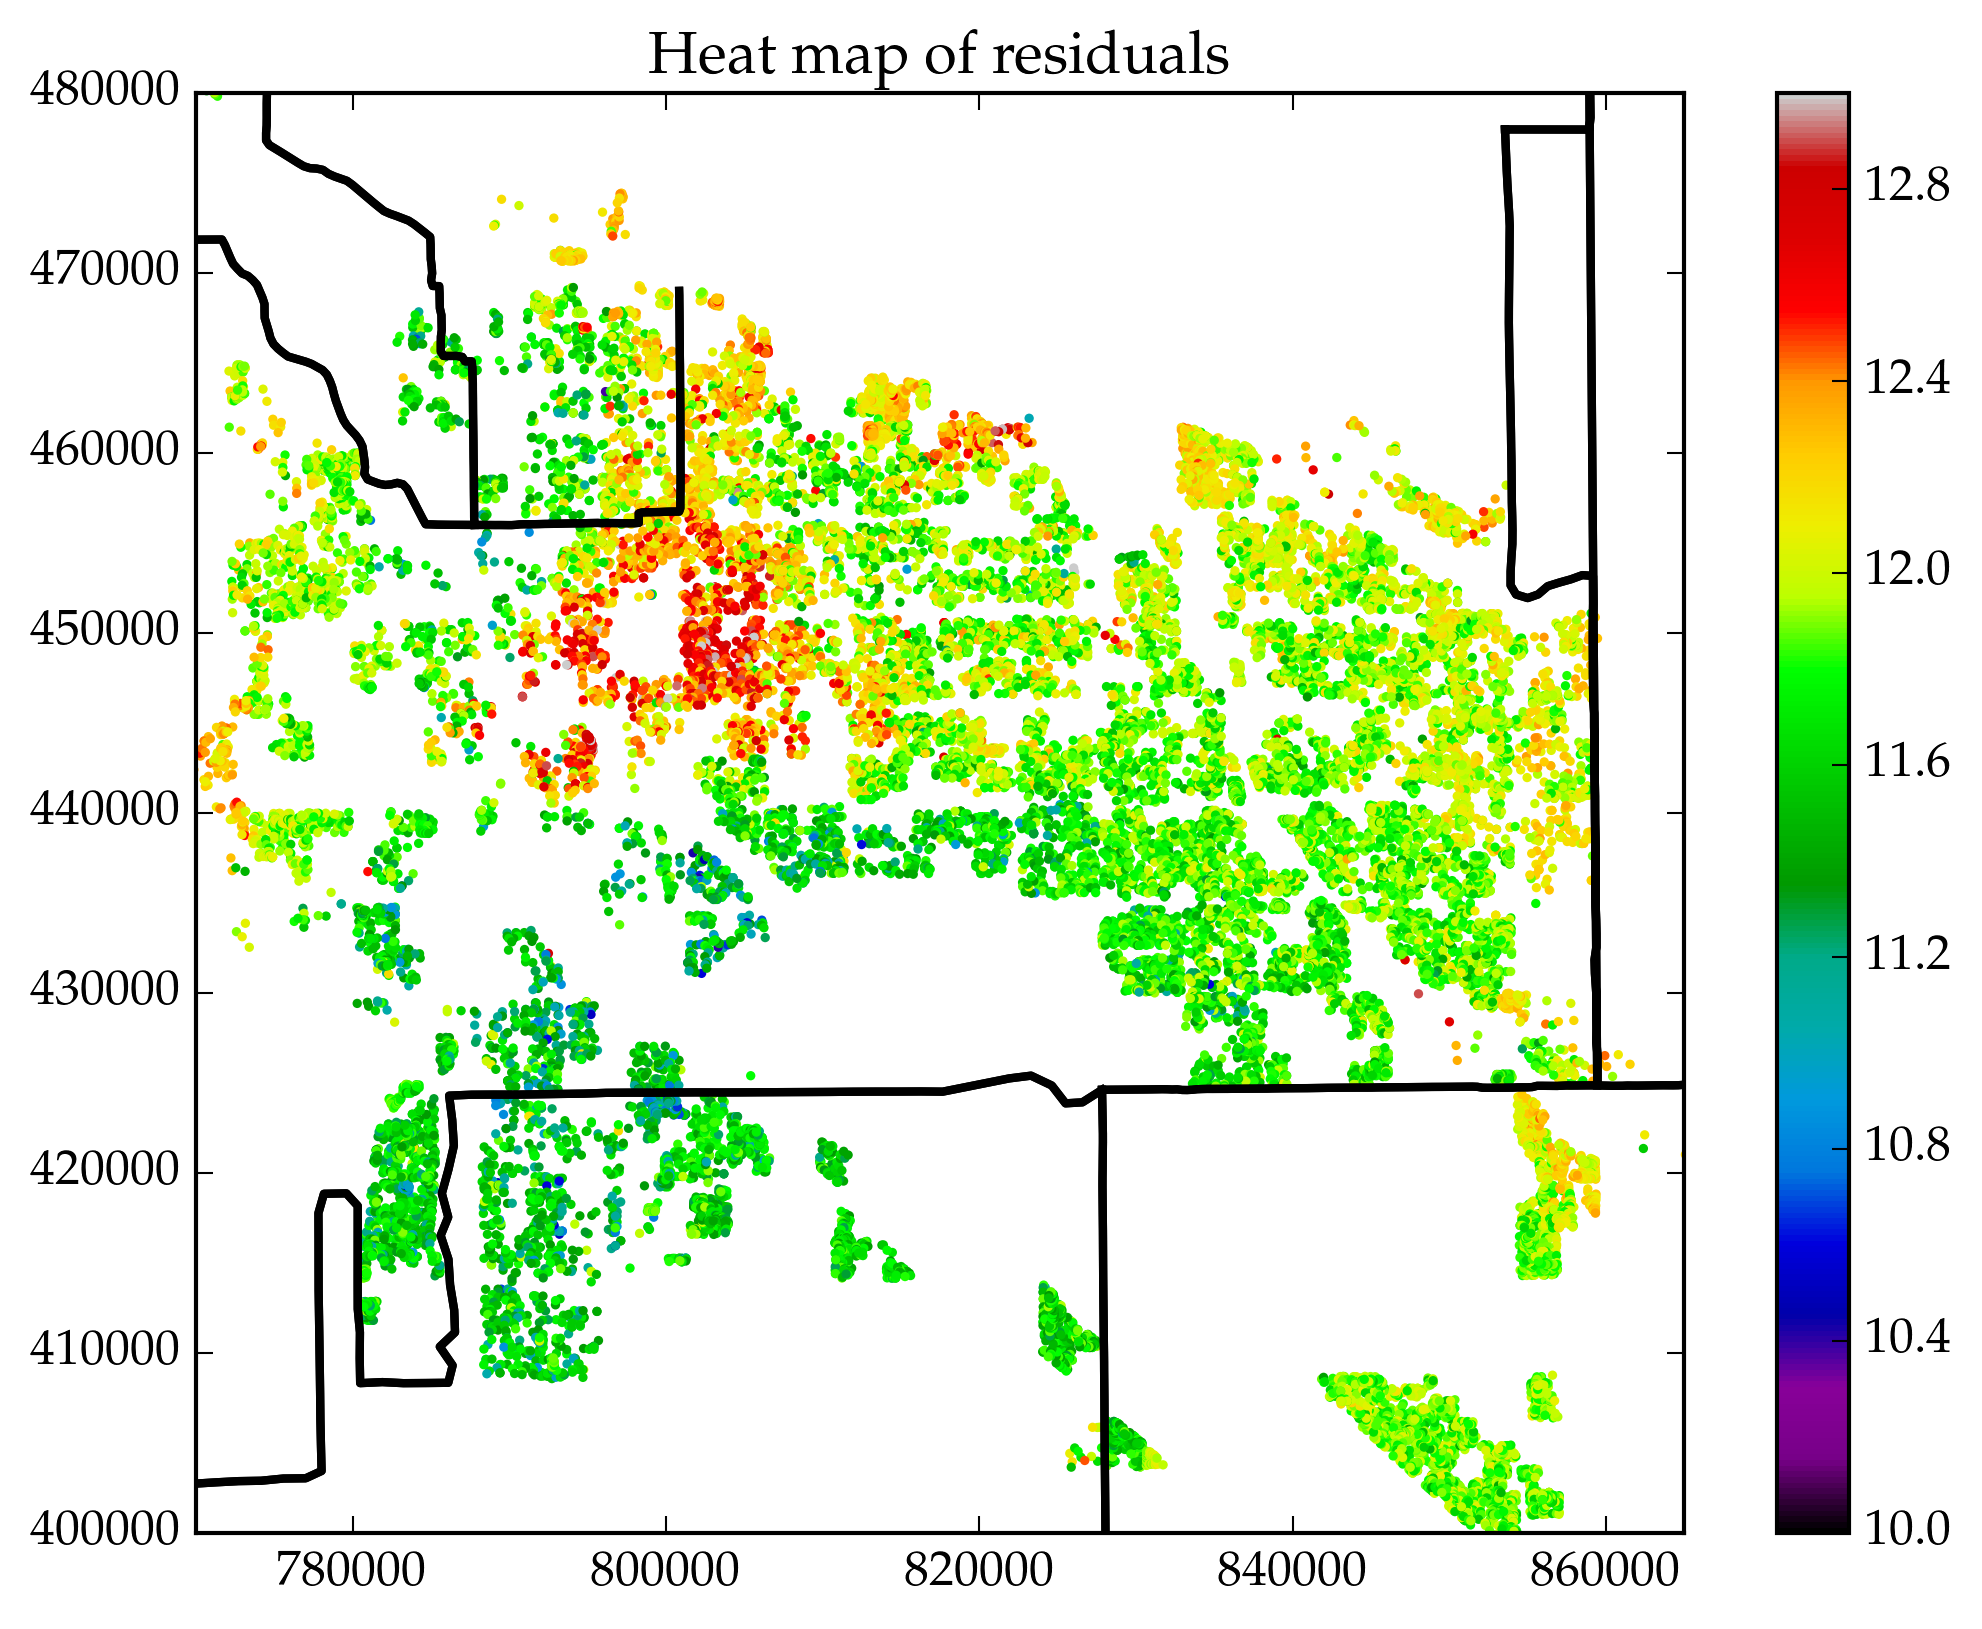

In [65]:
for name in schdistrs
    plt.scatter(X_dict[name]'[1,:], X_dict[name]'[2,:],c=resid_dict[name], s=5, 
        cmap="spectral", edgecolor="None", vmin=10.0, vmax=13.0)
end
for (key,val) in sentinels
    X◫ = hcat(val.coordinates...)
    plt.plot(X◫[1,:], X◫[2,:], color="black", linewidth=2)
end
plt.title("Heat map of residuals")
plt.xlim(770000,865000)
plt.ylim(400000,480000)
plt.colorbar()
;